In [16]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.units import rad, s, Hz

import pulsar

# Pulsar Profiling

Neutron stars have strong magnetic fields that emit beams of radiation from 
their magnetic poles. As the star rotates over its spin axis, the radiation beam
is seen once for every rotation of the star when an observer becomes aligned
with the magnetic axis.

From the point of view of an observer, the star's brightness is increased many
folds during this short period, creating a distinct pulse, hence the name
pulsating star, or pulsar. However, because the star's rotation and magnetic
axes can be distinct, the observed brightness varies during the precessional
motion.

In this project we use computational techniques to simulate and plot a pulsar
profile in which its observed brightness follows the von Mises distribution,
a continuous probability distribution on a circular plane with a range from 0
to 2 $\pi$.

$$I(\phi \, | \, \mu,\kappa) = I_{peak}e^{\kappa\, cos(\phi-\mu)}$$

Where:

* $\phi$ is the pulsar phase which depends on its angular frequency
* $I_{peak}$ is the peak observed brightness
* $\mu$ is the mean direction of the distribution ($0 \leq \mu \leq 2 \pi$)
* $\kappa$ is the concentration parameter, the reciprocal of dispersion,
defined as:

$$\kappa = \frac{log \, 2}{2\, sin^2(\pi D/2)}$$

When $\kappa = 0$ the distribution is uniform, but for a pulsar its
concentration value depends on $D$, the duty cycle. The duty cycle is the ratio
of pulse width to the period of repetition of the pulse.

Examples of duty cycles of detected pulsars (Henry and Paik, 1969):

<div>
<img src="dutycycle.png" alt="Duty Cycles" width="400px">
</div> 

References:

* Grafarend, E. & Awange. J. (2012) Applications of Linear and Nonlinear Models:
Fixed Effects, Random Effects. Springer Science & Business Media, Aug 15.
(p. 362)
* Henty, G., Paik, HJ. Distribution of Pulsar Duty Cycles. Nature 224, 1188–1189
(1969). https://doi.org/10.1038/2241188a0

## Scenario Constants

For this project we use the following constants for the observed intensity
function:

* $\phi_{0} = 1$ ($\phi$ at $t_0$)
* $I_{peak} = 100$ 
* $\mu = 1$
* $D = 0.1$
* T = 10ms which results in a frequency $\approx 1.6$ kHz, $53\times$ faster than the
    Crab Nebula

In [17]:
# Global settings for plot size
plt.rcParams["figure.figsize"] = (20, 5)

# Pulsar scenario constants
D = 0.1             # duty cycle number
phi0 = 1 * rad    # initial angle value
Ipeak = 100         # amplitude of intensity
period = 0.01 * s # rotational period (10 ms)

## Simulated brightness time series

Using the scenario constants we simulate a time series from 0 to 2s with 500Hz
sample rate.

The first plot shows the entire 2s period in which we can see the observed
brightness varying from its highest peak at $I(t=0) \approx 1.4 \cdot 10^8$
to its lowest peak at $I(t=1s) \approx 9^6$. Therefore, from an observer the
pulse increases by 2 orders of magnitude when the beam is in phase.

The next two plots show individual pulses at its highest and lowest observed
brightness. From both images we can see one pulse for each rotational period
(0.01s).

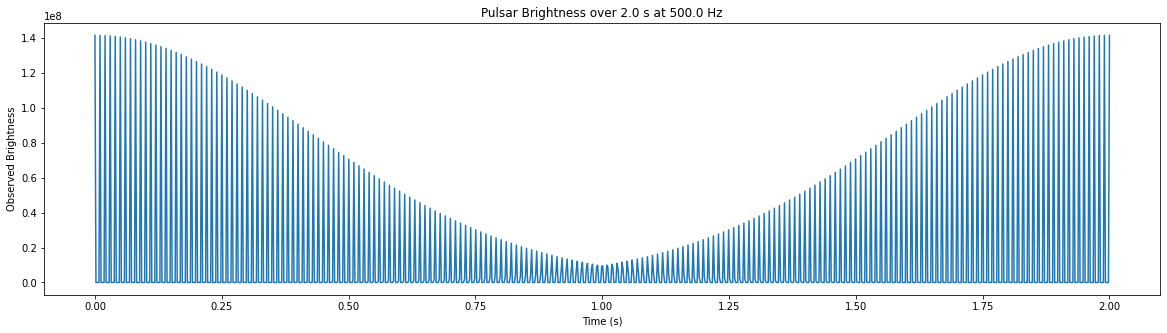

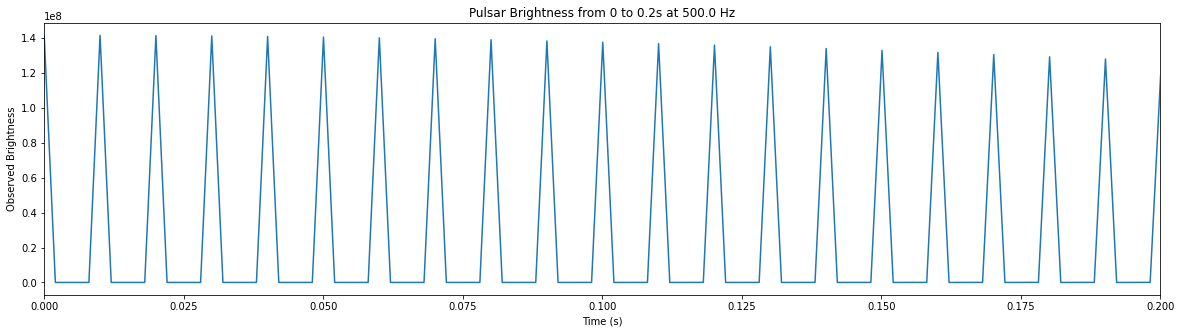

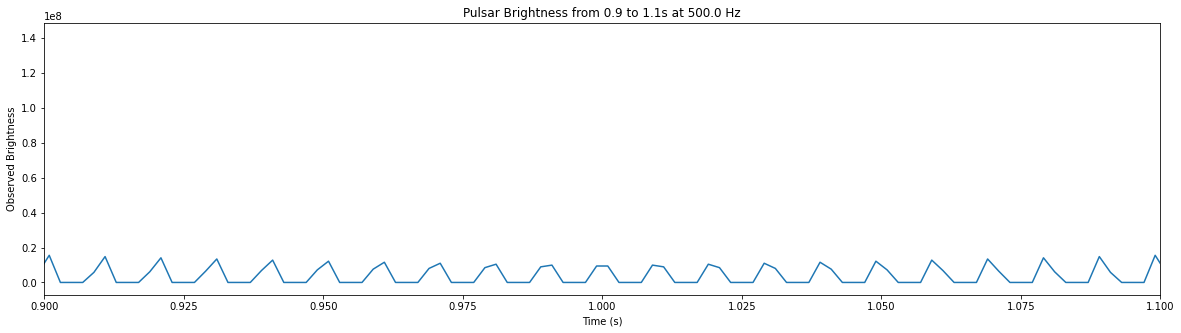

In [26]:
time = 2 * s
rate = 500 * Hz

def plot_brightness(time: s, rate: Hz, xlim=()):

    num = int(time * rate)

    tframe = np.linspace(0, time.value, num) * s
    brightness = pulsar.linear_brightness(phi0, D, period, Ipeak, tframe)

    plt.plot(tframe, brightness)
    plt.xlabel('Time (s)')
    plt.ylabel('Observed Brightness')
    if len(xlim) == 2:
        min = xlim[0]
        max = xlim[1]
        plt.xlim(xlim[0], xlim[1])
        plt.title(f'Pulsar Brightness from {min} to {max}s at {rate}')
    else:
        plt.title(f'Pulsar Brightness over {time} at {rate}')
    plt.show()

plot_brightness(time, rate)
plot_brightness(time, rate, (0, 0.20))
plot_brightness(time, rate, (0.9, 1.1))

Using different sample rates over the same period it is possible to see how
constructive and destructive interference patterns affect the signal. When
sampling at 333 Hz instead the signal becomes less clear since the detection
is out of phase.

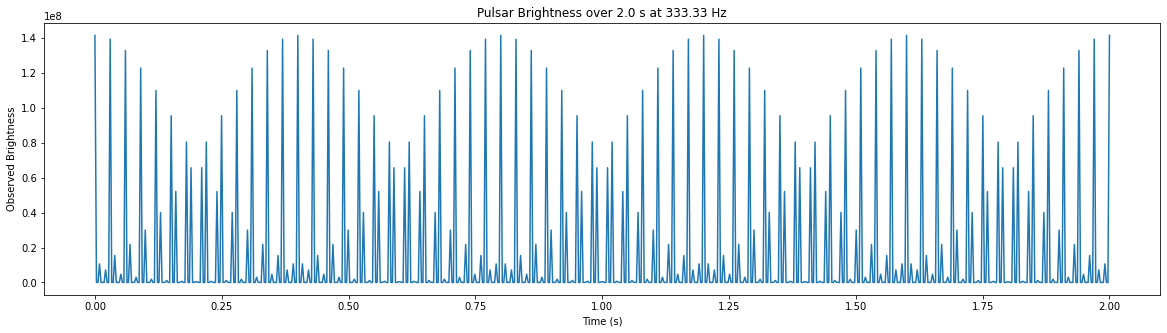

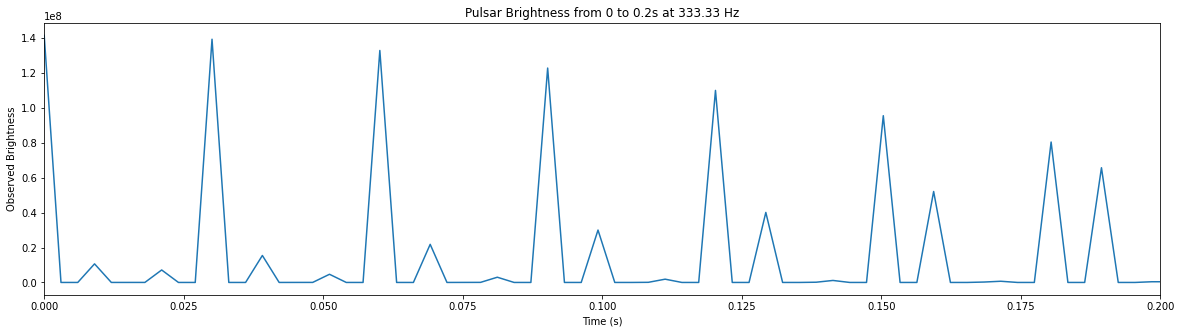

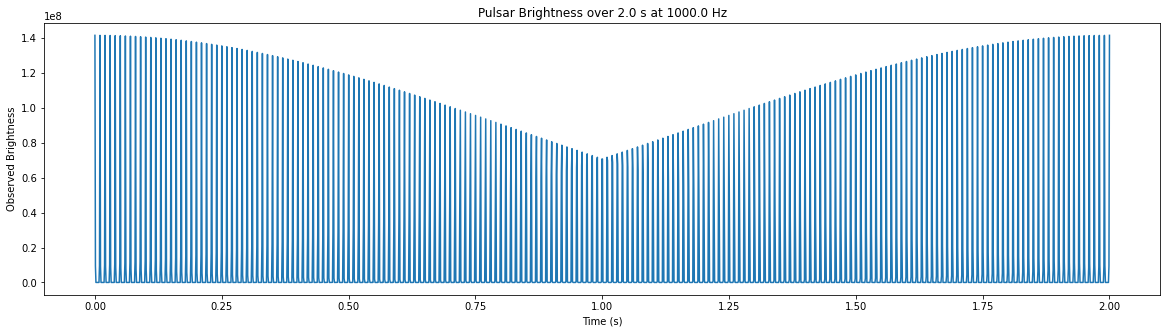

In [28]:
plot_brightness(time, 333.33*Hz)
plot_brightness(time, 333.33*Hz, (0, 0.20))
plot_brightness(time, 2000*Hz)

## Integrated Brightness

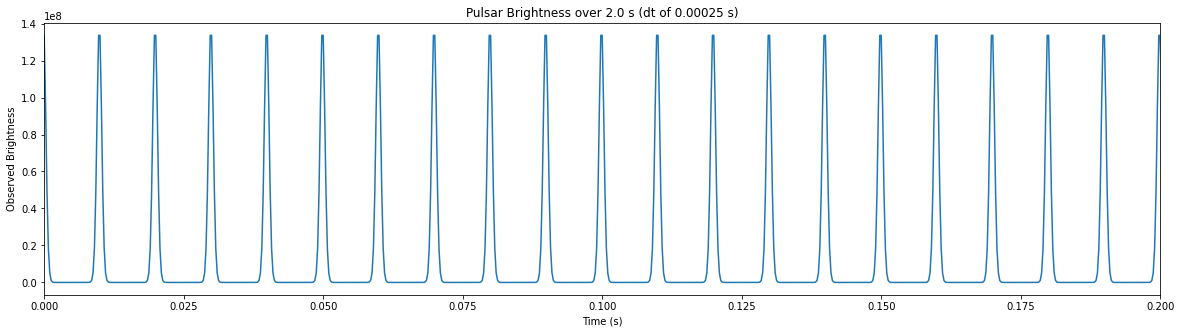

In [20]:
# Integrate the brigthness with a dt of 0.25ms
dt = 0.00025 * s # 0.25ms
steps = np.arange(0, time.value, dt.value)

brightness = pulsar.integrated_brightness(phi0, D, period, Ipeak, dt, steps)

plt.plot(steps[:-1], brightness)
plt.title(f'Pulsar Brightness over {time} (dt of {dt})')
plt.xlabel('Time (s)')
plt.ylabel('Observed Brightness')
plt.xlim(0, 0.2)
plt.show()

## Adding noise

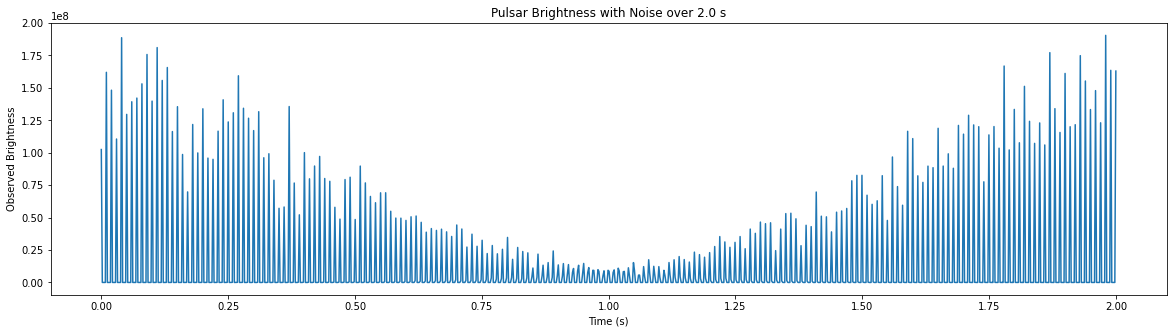

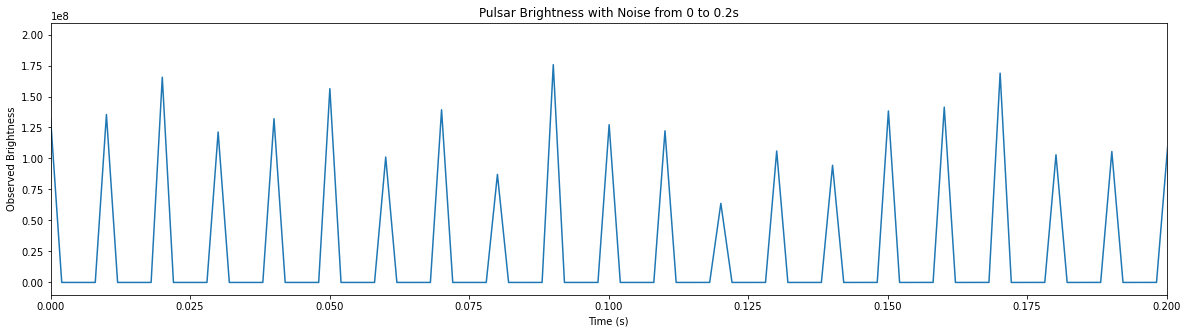

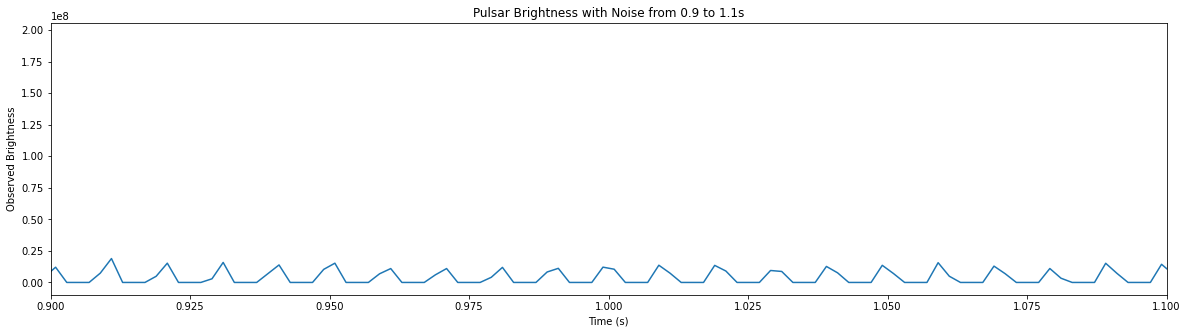

In [21]:
def plot_noisy_brightness(time: s, sample_rate: int, xlim=()):

    stddev = Ipeak * 0.2
    tframe = np.linspace(0, time.value, sample_rate) * s
    brightness = pulsar.noisy_brightness(phi0, D, period, Ipeak, stddev, tframe)

    plt.plot(tframe, brightness)
    plt.xlabel('Time (s)')
    plt.ylabel('Observed Brightness')
    if len(xlim) == 2:
        min = xlim[0]
        max = xlim[1]
        plt.xlim(xlim[0], xlim[1])
        plt.title(f'Pulsar Brightness with Noise from {min} to {max}s')
    else:
        plt.title(f'Pulsar Brightness with Noise over {time}')
    plt.show()

plot_noisy_brightness(time, 1000)
plot_noisy_brightness(time, 1000, (0, 0.20))
plot_noisy_brightness(time, 1000, (0.9, 1.1))